# Outline of BL Algorithm 

## I: Base Model
* Step 1: Initialize the setup, including the (annualized returns), standard deviations, correlations and covariance of bond and stock and their, e.g., $R_B,R_S, \sigma_B, \sigma_S, \rho, Cov(R_B,R_S)$ and the risk-aversion parameter $\bar{A}$.

* Step 2: Work out the varaince of base model
\begin{equation}
Var(R_M) = w^2_B Var(R_B) + w^2_SVar(R_S)+2w_B w_S Cov(R_B,R_S),
\end{equation}
where $w_B$ ad $w_S$ are the weight of bond and stock with $w_B+w_S=1$. Moreover, the reurn of the base model is given by
\begin{equation}
E[R_M] = \bar{A} \times Var(R_M).
\end{equation}

* Step 3: Base Model's Forecast

The equilibrium risk premium on bonds and stocks can be inferred from the betas on the baseline portfolio:
\begin{equation}
\begin{split}
Cov(R_B,R_S)& = Cov(R_B,w_B R_B + w_S R_S),\\
E[R_B] &= \frac{Cov(R_B,R_M)}{Var(R_M)}E[R_M],\\
E[R_S] &= \frac{Cov(R_S,R_M)}{Var(R_M)}E[R_M].
\end{split}
\end{equation}
As such, the expected returns fo bond and stock are worked out.

* Step 4: Covariance of Base Model's Forecast 

Initialize the precision of forecast with the matrix $Cov(E[R_B],E[R_S])$.

## II: Incorporation of Manager's View
* Step 5: Setup for manager's view
\begin{equation}
\begin{split}
PR' &= Q + \epsilon,\\
P  &= (1,-1),\\
R & = (R_B, R_S),
\end{split}
\end{equation}
with the variance of the view of $\sigma^2(\epsilon)$.

* Step 6: Revised (Posterior) Expectations:
Using the BL linear-equation notation for market's view
\begin{equation}
\begin{split}
P  &= (1,-1),\\
R_E & = [E(R_B), E(R_S)],\\
Q^E &= PR'_E.
\end{split}
\end{equation}
Moreover, work out the difference of the manager's view and market view
\begin{equation}
\begin{split}
D &= Q - Q^E, \\
\sigma^2(Q^E) &= Var[E(R_B)-E[R_S)], \\
\sigma^2(D) &= \sigma^2(\epsilon) + \sigma^2(Q^E).
\end{split}
\end{equation}
Finally, update the expected returns of bond and stock, conditional on the manager's view:
\begin{equation}
\begin{split}
E[R_B|P) &= E[R_B] + \frac{D(\sigma^2_{E[R_B]}-Cov(E[R_B],E[R_S])}{\sigma^2(D)},\\
E[R_S|P) &= E[R_S] + \frac{D(Cov(E[R_B],E[R_S]-\sigma^2_{E[R_S]})}{\sigma^2(D)}.
\end{split}
\end{equation}

## III: Update on Optimal Portfolio

* Step 6: Work out the optimal portfolio (with the highest Sharpe ratio) using updated returns:
\begin{equation}
\begin{split}
w_B &= \frac{E(R_B)\sigma^2_S - E(R_S)Cov(R_B, R_S)}{E(R_B)\sigma^2_S +E(R_S)\sigma^2_B - [E(R_S)+E(R_B)]Cov(R_B, R_S)},\\
w_S &= 1 - w_B,
\end{split}
\end{equation}
where $E(R_B) = E[R_B|P)$ and $E(R_S) = E[R_S|P)$.

In [ ]:
# Setup
# 

# Suppose you are the fund manager who constructs a portfolio from a stock and a bond.
# Tasks:
#  1) incoporate the fund manager's view into the construction of portfolios
#  2) examine the sensitivity of the portfolio perfomrance related to the confidence

In [58]:
# Task 1:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
 
def BaseLineModel(parameters_portfolio): #step 2
    Cov_bs = parameters_portfolio['Hist_stats']['Cov']    
    weights = parameters_portfolio['baseline']['weights']
    
    Var_M = weights[0,0]**2*Cov_bs[0,0] + weights[0,1]**2*Cov_bs[1,1] \
            + 2*weights[0,0]*weights[0,1]*Cov_bs[0,1]
    
    E_r_M = parameters_portfolio['baseline']['risk_aversion']*Var_M
    
    Cov_b_M = weights[0,0]*Cov_bs[0,0] + weights[0,1]*Cov_bs[0,1]
    Cov_s_M = weights[0,0]*Cov_bs[0,1] + weights[0,1]*Cov_bs[1,1]
    
    E_r_b = (Cov_b_M/Var_M)*E_r_M
    E_r_s = (Cov_s_M/Var_M)*E_r_M
    
    print('E_r_b='+str(E_r_b)+',E_r_s='+str(E_r_s))
    
    return E_r_b, E_r_s, E_r_M, Var_M
    
def UpdateStats(parameters_portfolio):    
    temp_qe = np.dot(parameters_portfolio['view']['P'],np.transpose(parameters_portfolio['baseline']['E_RS']))
    Q_E = temp_qe[0,0]
    
    Q = parameters_portfolio['view']['Q']
    D = Q - Q_E
    
    Var_epsilon = parameters_portfolio['view']['sigma_epsilon']**2                
    Cov_ERS = parameters_portfolio['baseline']['Cov_ERS']                     
    Var_QE = Cov_ERS[0,0] + Cov_ERS[1,1] - 2* Cov_ERS[0,1]
    Var_D =  Var_epsilon + Var_QE
                     
    return Q_E, D, Var_QE, Var_D

def UpdateExpectedReturn(parameters_portfolio):                     
    
    Cov_ERS = parameters_portfolio['baseline']['Cov_ERS']
    Var_E_RB = Cov_ERS[0,0]
    Var_E_RS = Cov_ERS[1,1]
    Cov_E_RBS = Cov_ERS[0,1]
      
    D = parameters_portfolio['view']['D']
    Var_D =  parameters_portfolio['view']['Var_D']                
    
    E_bs = parameters_portfolio['baseline']['E_RS'] 
    E_r_b_P = E_bs[0,0] + D*(Var_E_RB - Cov_E_RBS)/Var_D
    E_r_s_P = E_bs[0,1] + D*(Cov_E_RBS - Var_E_RS)/Var_D
                     
    return E_r_b_P, E_r_s_P    

def OptimalWeightMV(parameters_portfolio):
                     
    r_f = parameters_portfolio['Hist_stats']['r_f']
                     
    Cov_bs = parameters_portfolio['Hist_stats']['Cov']
    Var_b = Cov_bs[0,0]
    Var_s = Cov_bs[1,1]
    Var_bs = Cov_bs[0,1]
             
    E_b =  parameters_portfolio['view']['E_RB_P']-r_f                 
    E_s =  parameters_portfolio['view']['E_RS_P']-r_f
                     
    item_1 = E_b*Var_s - E_s*Var_bs
    item_2 = E_b*Var_s + E_s*Var_b - (E_b+E_s)*Var_bs
    w_d = item_1/item_2
    w_s = 1 - w_d                 
    
    E_p = w_d * parameters_portfolio['view']['E_RB_P'] \
        + w_s * parameters_portfolio['view']['E_RS_P']
    #E_p = w_d * E_b + w_s * E_s  
                     
    return w_d, w_s, E_p

# main function
if __name__ == '__main__':

    # Define data structure    
    parameters_portfolio ={
                           'Hist_stats':{'sigma':np.array([[0,0]]),
                                         'Cov':np.array([[0,0],[0,0]]),
                                         'rpho':0,
                                         'r_f':0,
                                         },
                           'baseline':{'weights':np.array([[0,0]]), 
                                        'E_RM':0,
                                        'Var_M':0,
                                        'E_RS':np.array([[0,0]]),   #[E_RB, E_RS]: forecasts from the baseline   
                                        'Cov_ERS':np.array([[0,0],[0,0]]),
                                        'risk_aversion':3},
                           'view':{'P':np.array([[1,-1]]),
                                   'Q':0,
                                   'sigma_epsilon':0,
                                   'Q_E':0,
                                   'D':0, 
                                   'Var_D':0,
                                   'Var_QE':0,
                                   'E_RB_P':0,
                                   'E_RS_P':0
                                  }
                          }
    
    # Step 1: Covariance Matrix from Historical Data
    parameters_portfolio['Hist_stats']['sigma'] = np.array([[0.08,0.17]])
    parameters_portfolio['Hist_stats']['Cov'] = np.array([[0.0064,0.00408],[0.00408,0.0289]])
    parameters_portfolio['Hist_stats']['rpho'] = 0.3
    parameters_portfolio['Hist_stats']['r_f'] = 0.0    
    

    # Set up a baseline model
    parameters_portfolio['baseline']['weights'] = np.array([[0.25,0.75]])
    [E_r_b, E_r_s, E_r_m, Var_m] = BaseLineModel(parameters_portfolio)
    parameters_portfolio['baseline']['E_RM'] = E_r_m
    parameters_portfolio['baseline']['Var_M'] = Var_m
    parameters_portfolio['baseline']['E_RS'] = np.array([[E_r_b,E_r_s]])
    parameters_portfolio['baseline']['Cov_ERS'] = parameters_portfolio['Hist_stats']['Cov']/100
    
    # initialize a view
    parameters_portfolio['view']['P'] = np.array([[1,-1]])  # [1,-1] bond outperform stock [-1, 1] stock outperform bond
    parameters_portfolio['view']['Q'] = 0.06
    parameters_portfolio['view']['sigma_epsilon'] = 0.0173  # confidence level
    
    #print(parameters_portfolio)
    
    # Revise Expectations
    [Q_E, D, Var_QE, Var_D] = UpdateStats(parameters_portfolio)
    parameters_portfolio['view']['Q_E'] = Q_E
    parameters_portfolio['view']['D'] = D
    parameters_portfolio['view']['Var_QE'] = Var_QE
    parameters_portfolio['view']['Var_D'] = Var_D
                     
    #print(parameters_portfolio)
    
    [E_RB_P, E_RS_P] = UpdateExpectedReturn(parameters_portfolio)
    parameters_portfolio['view']['E_RB_P'] = E_RB_P
    parameters_portfolio['view']['E_RS_P'] = E_RS_P   
    
    print(parameters_portfolio)
    
    # Calcluate the optimal weights in the mean-variance framework
    [w_d, w_s, E_p] = OptimalWeightMV(parameters_portfolio)                     
    print('w_d='+str(w_d)+',w_s='+str(w_s)+', E_p='+ str(E_p))
    
    M_2 = E_p - parameters_portfolio['baseline']['E_RM']    
    print('M^2='+str(M_2))
                     
    

E_r_b=0.01398,E_r_s=0.068085
{'Hist_stats': {'sigma': array([[0.08, 0.17]]), 'Cov': array([[0.0064 , 0.00408],
       [0.00408, 0.0289 ]]), 'rpho': 0.3, 'r_f': 0.0}, 'baseline': {'weights': array([[0.25, 0.75]]), 'E_RM': 0.05455875, 'Var_M': 0.01818625, 'E_RS': array([[0.01398 , 0.068085]]), 'Cov_ERS': array([[6.40e-05, 4.08e-05],
       [4.08e-05, 2.89e-04]]), 'risk_aversion': 3}, 'view': {'P': array([[ 1, -1]]), 'Q': -0.01, 'sigma_epsilon': 0.0173, 'Q_E': -0.05410500000000001, 'D': 0.044105000000000005, 'Var_D': 0.00057069, 'Var_QE': 0.0002714, 'E_RB_P': 0.015772980427202158, 'E_RS_P': 0.04890320077450105}}
w_d=0.5076121303451376,w_s=0.49238786965486236, E_p=0.032085899045204834
M^2=-0.02247285095479517


   epislon       w_d        M2
0   0.0000  0.975927 -0.035647
1   0.0100  0.780470 -0.034491
2   0.0173  0.595225 -0.027653
3   0.0300  0.418189 -0.015897
4   0.0600  0.300890 -0.005296


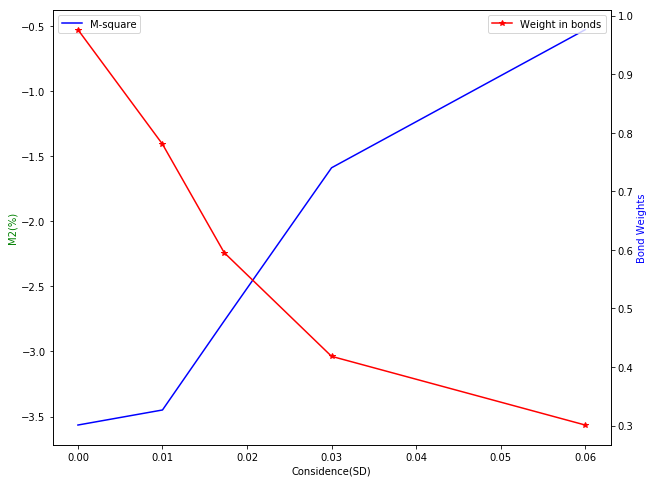

In [8]:
# Task 2:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
 
def BaseLineModel(parameters_portfolio): #step 2
    Cov_bs = parameters_portfolio['Hist_stats']['Cov']    
    weights = parameters_portfolio['baseline']['weights']
    
    Var_M = weights[0,0]**2*Cov_bs[0,0] + weights[0,1]**2*Cov_bs[1,1] \
            + 2*weights[0,0]*weights[0,1]*Cov_bs[0,1]
    
    E_r_M = parameters_portfolio['baseline']['risk_aversion']*Var_M
    
    Cov_b_M = weights[0,0]*Cov_bs[0,0] + weights[0,1]*Cov_bs[0,1]
    Cov_s_M = weights[0,0]*Cov_bs[0,1] + weights[0,1]*Cov_bs[1,1]
    
    E_r_b = (Cov_b_M/Var_M)*E_r_M
    E_r_s = (Cov_s_M/Var_M)*E_r_M
    
    #print('E_r_b='+str(E_r_b)+',E_r_s='+str(E_r_s))
    
    return E_r_b, E_r_s, E_r_M, Var_M
    
def UpdateStats(parameters_portfolio):    
    temp_qe = np.dot(parameters_portfolio['view']['P'],np.transpose(parameters_portfolio['baseline']['E_RS']))
    Q_E = temp_qe[0,0]
    
    Q = parameters_portfolio['view']['Q']
    D = Q - Q_E
    
    Var_epsilon = parameters_portfolio['view']['sigma_epsilon']**2                
    Cov_ERS = parameters_portfolio['baseline']['Cov_ERS']                     
    Var_QE = Cov_ERS[0,0] + Cov_ERS[1,1] - 2* Cov_ERS[0,1]
    Var_D =  Var_epsilon + Var_QE
                     
    return Q_E, D, Var_QE, Var_D

def UpdateExpectedReturn(parameters_portfolio):                     
    
    Cov_ERS = parameters_portfolio['baseline']['Cov_ERS']
    Var_E_RB = Cov_ERS[0,0]
    Var_E_RS = Cov_ERS[1,1]
    Cov_E_RBS = Cov_ERS[0,1]
      
    D = parameters_portfolio['view']['D']
    Var_D =  parameters_portfolio['view']['Var_D']                
    
    E_bs = parameters_portfolio['baseline']['E_RS'] 
    E_r_b_P = E_bs[0,0] + D*(Var_E_RB - Cov_E_RBS)/Var_D
    E_r_s_P = E_bs[0,1] + D*(Cov_E_RBS - Var_E_RS)/Var_D
                     
    return E_r_b_P, E_r_s_P    

def OptimalWeightMV(parameters_portfolio):
                     
    r_f = parameters_portfolio['Hist_stats']['r_f']
                     
    Cov_bs = parameters_portfolio['Hist_stats']['Cov']
    Var_b = Cov_bs[0,0]
    Var_s = Cov_bs[1,1]
    Var_bs = Cov_bs[0,1]
             
    E_b =  parameters_portfolio['view']['E_RB_P']-r_f                 
    E_s =  parameters_portfolio['view']['E_RS_P']-r_f
                     
    item_1 = E_b*Var_s - E_s*Var_bs
    item_2 = E_b*Var_s + E_s*Var_b - (E_b+E_s)*Var_bs
    w_d = item_1/item_2
    w_s = 1 - w_d                 
    
    E_p = w_d * parameters_portfolio['view']['E_RB_P'] \
        + w_s * parameters_portfolio['view']['E_RS_P']
    #E_p = w_d * E_b + w_s * E_s  
                     
    return w_d, w_s, E_p

# main function
if __name__ == '__main__':

    # Define data structure    
    parameters_portfolio ={
                           'Hist_stats':{'sigma':np.array([[0,0]]),
                                         'Cov':np.array([[0,0],[0,0]]),
                                         'rpho':0,
                                         'r_f':0,
                                         },
                           'baseline':{'weights':np.array([[0,0]]), 
                                        'E_RM':0,
                                        'Var_M':0,
                                        'E_RS':np.array([[0,0]]),   #[E_RB, E_RS]: forecasts from the baseline   
                                        'Cov_ERS':np.array([[0,0],[0,0]]),
                                        'risk_aversion':3},
                           'view':{'P':np.array([[1,-1]]),
                                   'Q':0,
                                   'sigma_epsilon':0,
                                   'Q_E':0,
                                   'D':0, 
                                   'Var_D':0,
                                   'Var_QE':0,
                                   'E_RB_P':0,
                                   'E_RS_P':0
                                  }
                          }
    
    # Step 1: Covariance Matrix from Historical Data
    parameters_portfolio['Hist_stats']['sigma'] = np.array([[0.08,0.17]])
    parameters_portfolio['Hist_stats']['Cov'] = np.array([[0.0064,0.00408],[0.00408,0.0289]])
    parameters_portfolio['Hist_stats']['rpho'] = 0.3
    parameters_portfolio['Hist_stats']['r_f'] = 0.0    
    

    # Set up a baseline model
    parameters_portfolio['baseline']['weights'] = np.array([[0.25,0.75]])
    [E_r_b, E_r_s, E_r_m, Var_m] = BaseLineModel(parameters_portfolio)
    parameters_portfolio['baseline']['E_RM'] = E_r_m
    parameters_portfolio['baseline']['Var_M'] = Var_m
    parameters_portfolio['baseline']['E_RS'] = np.array([[E_r_b,E_r_s]])
    parameters_portfolio['baseline']['Cov_ERS'] = parameters_portfolio['Hist_stats']['Cov']/100
    
    # initialize a view
    parameters_portfolio['view']['Q'] = 0.005    
    parameters_portfolio['view']['P'] = np.array([[1,-1]])  # [1,-1] bond outperform stock [-1, 1] stock outperform bond
    
    # sensitivity check
    sigma_e = [0, 0.0100, 0.0173,0.0300,0.0600]    
    #sigma_e = np.array([0.0173])    
    wd_m2s = np.zeros([len(sigma_e),2])
    
    parameters_portfolio_sen = parameters_portfolio
    for i in range(0,len(sigma_e)):
    
        parameters_portfolio_sen['view']['sigma_epsilon'] = sigma_e[i]  # confidence level
        #print('sigma_e'+str(sigma_e[i]))

        # Revise Expectations
        [Q_E, D, Var_QE, Var_D] = UpdateStats(parameters_portfolio_sen)
        parameters_portfolio_sen['view']['Q_E'] = Q_E
        parameters_portfolio_sen['view']['D'] = D
        parameters_portfolio_sen['view']['Var_QE'] = Var_QE
        parameters_portfolio_sen['view']['Var_D'] = Var_D

        [E_RB_P, E_RS_P] = UpdateExpectedReturn(parameters_portfolio_sen)
        parameters_portfolio_sen['view']['E_RB_P'] = E_RB_P
        parameters_portfolio_sen['view']['E_RS_P'] = E_RS_P   

        #print(parameters_portfolio_sen)

        # Calcluate the optimal weights in the mean-variance framework
        [w_d, w_s, E_p] = OptimalWeightMV(parameters_portfolio_sen)                     
        #print('w_d='+str(w_d)+',w_s='+str(w_s)+', E_p='+ str(E_p))

        M_2 = E_p - parameters_portfolio_sen['baseline']['E_RM']    
        #print('M^2='+str(M_2))
        
        wd_m2s[i,:] = np.array([[w_d, M_2]])
        
    # pack all results
    DF_sigma_e = pd.DataFrame(np.transpose(sigma_e))    
    DF_wd_m2s = pd.DataFrame(wd_m2s)
    W_M2 = pd.concat([DF_sigma_e,DF_wd_m2s], axis=1)
    W_M2.columns = ['epislon','w_d', 'M2']
    W_M2.to_csv('BL_model.csv') 
    print(W_M2)
    
    #plot
    fig, ax1 = plt.subplots(figsize=(10, 8))    
    ax2 = ax1.twinx()
    ax1.plot(W_M2['epislon'][:],W_M2['M2'][:]*100,'b-', label='M-square') 
    ax1.legend(loc=0)
    ax2.plot(W_M2['epislon'][:],W_M2['w_d'][:],'r-*', label='Weight in bonds')
    ax2.legend(loc=0)
    ax1.set_xlabel('Considence(SD)')
    ax1.set_ylabel('M2(%)',color='g') 
    ax2.set_ylabel('Bond Weights',color='b') 
    plt.show()
    
   
    

   epislon  w_d   M2
0   0.0000  0.0  0.0
1   0.0100  NaN  NaN
2   0.0173  NaN  NaN
3   0.0300  NaN  NaN
4   0.0600  NaN  NaN


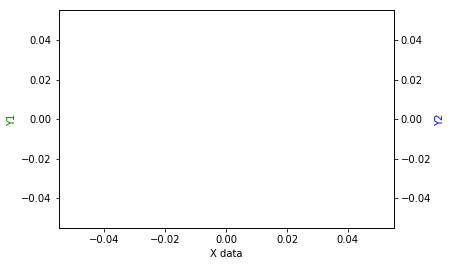

In [4]:
import numpy as np
import pandas as pd

# A = np.array([[1,-1]])
# print(A[0,1])

# B = np.array([[1,-1],[0,2]])
# print(B[1,1])

# C = np.dot(np.array([[1,-1]]),np.transpose(np.array([[0.014,0.0681]])))
# print(C[0,0])

sigma_e = np.array([[0, 0.0100, 0.0173,0.0300,0.0600]])    
wd_m2s = np.zeros([len(sigma_e),2])
m_2s = np.zeros([len(sigma_e),1])

#W_M2 = pd.DataFrame((np.transpose(sigma_e)))
DF_sigma_e = pd.DataFrame(np.transpose(sigma_e))    
DF_wd_m2s = pd.DataFrame(wd_m2s)
W_M2 = pd.concat([DF_sigma_e,DF_wd_m2s], axis=1)
W_M2.columns = ['epislon','w_d', 'M2']
print(W_M2)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(W_M2['epislon'][:],W_M2['w_d'][:],'g-')
ax2.plot(W_M2['epislon'][:],W_M2['M2'][:],'b-') 

ax1.set_xlabel("X data")
ax1.set_ylabel("Y1",color='g') 
ax2.set_ylabel("Y2",color='b') 
plt.show()
